In [8]:
import numpy as np
import pandas as pd
import json, pickle, time, random, os, re
from tqdm import tqdm
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

import yfinance as yf
from datetime import datetime, timedelta

plt.style.use('ggplot')


In [19]:
def get_date(lines):
    for l in lines:
        l = l.decode('utf-8')
        if l.startswith('Date:'):
            return l
    return 'NA'

In [54]:
def format_date(s_date):
    f_date = s_date.replace(' +0000\r\n','')
    f_date = f_date.replace('Date: ', '')
    f_date = f_date.split(', ')[1]
    f_date = datetime.strptime(f_date, '%d %b %Y %H:%M:%S')
    return f_date.strftime('%Y-%m-%d')
    

In [56]:
format_date('Date: Tue, 3 Oct 2020 12:13:38 +0000\r\n')

'2020-10-03'

In [57]:
def get_tickers_df(t_dict):
    df_data = list()
    for tick, date in t_dict.items():
        if isinstance(date, str):
            df_data.append((tick, format_date(date)))
        else:
            for d in date:
                df_data.append((tick, format_date(d)))
                
    return pd.DataFrame(data=df_data, columns=['Ticker', 'Date'])        

In [58]:
def get_tickers(dpath):
    tickers = list()
    tick_date = dict()
    files = [f for f in os.listdir(dpath) if f.endswith('.eml')]
    for f in tqdm(files):
        with open(f'{dpath}/{f}', 'rb') as f:
            lines = f.readlines()
        dt = get_date(lines)
        lines = [l.decode('utf-8') for l in lines if 'Last Close:' in l.decode('utf-8')]
        for l in lines:
            try:
                t = re.search(r'\[(.*?)\]', l).group()[1:-1]
                tickers.append(t)
                if t in tick_date:
                    if isinstance(tick_date[t],str) and dt != tick_date[t]:
                        o_val = tick_date[t]
                        tick_date[t] = list()
                        tick_date[t].append(o_val)
                        tick_date[t].append(dt)
                    elif dt not in tick_date[t]:
                        tick_date[t].append(dt)
                else:
                    tick_date[t] = dt
            except:
                pass
    return np.unique(tickers), get_tickers_df(tick_date)

In [3]:
tickers, tickers_date = get_tickers('/Users/zvissh/Downloads/etc')
ed = datetime.now()
st = ed - timedelta(days=180)
data = dict()

for t in tickers:
    data[t] = yf.download(t, start = st, end = ed)
    
print('ALL DONE!!!')

100%|██████████| 154/154 [00:00<00:00, 1171.72it/s]


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%********

In [4]:
def has_grown(df, ticker):
    try:
        cp = np.array(df[ticker]['Adj Close'].values)
        return (cp[-1] / cp[0]) > 2 and cp.mean() > 10
    except:
        print(ticker)
        return False

In [5]:
keys = list()
data_grow = dict()

for t in tickers:
    if has_grown(data, t):
        data_grow[t] = data[t]


t_cnt = len(data_grow)
t_cnt

HTZ
IPOC
MYOK
NNHIC
PIC
PRCP


21

['2020-12-31']
['2020-11-20' '2021-02-03']
['2020-09-28']
['2020-10-01']
['2020-10-08']
['2021-03-05']
['2020-09-22' '2020-10-09' '2021-01-27' '2021-02-25' '2021-02-26']
['2020-10-02']
['2020-11-25']
['2020-12-16']
['2020-11-04' '2021-02-10']
['2020-09-30' '2020-11-12' '2020-11-16' '2020-11-27' '2020-11-30'
 '2020-12-01']
['2021-01-11']
['2020-11-24' '2021-02-16']
['2021-02-25']
['2020-09-28']
['2020-12-08' '2021-02-19']
['2021-03-04']
['2020-10-21']
['2020-12-16']
['2021-02-24']


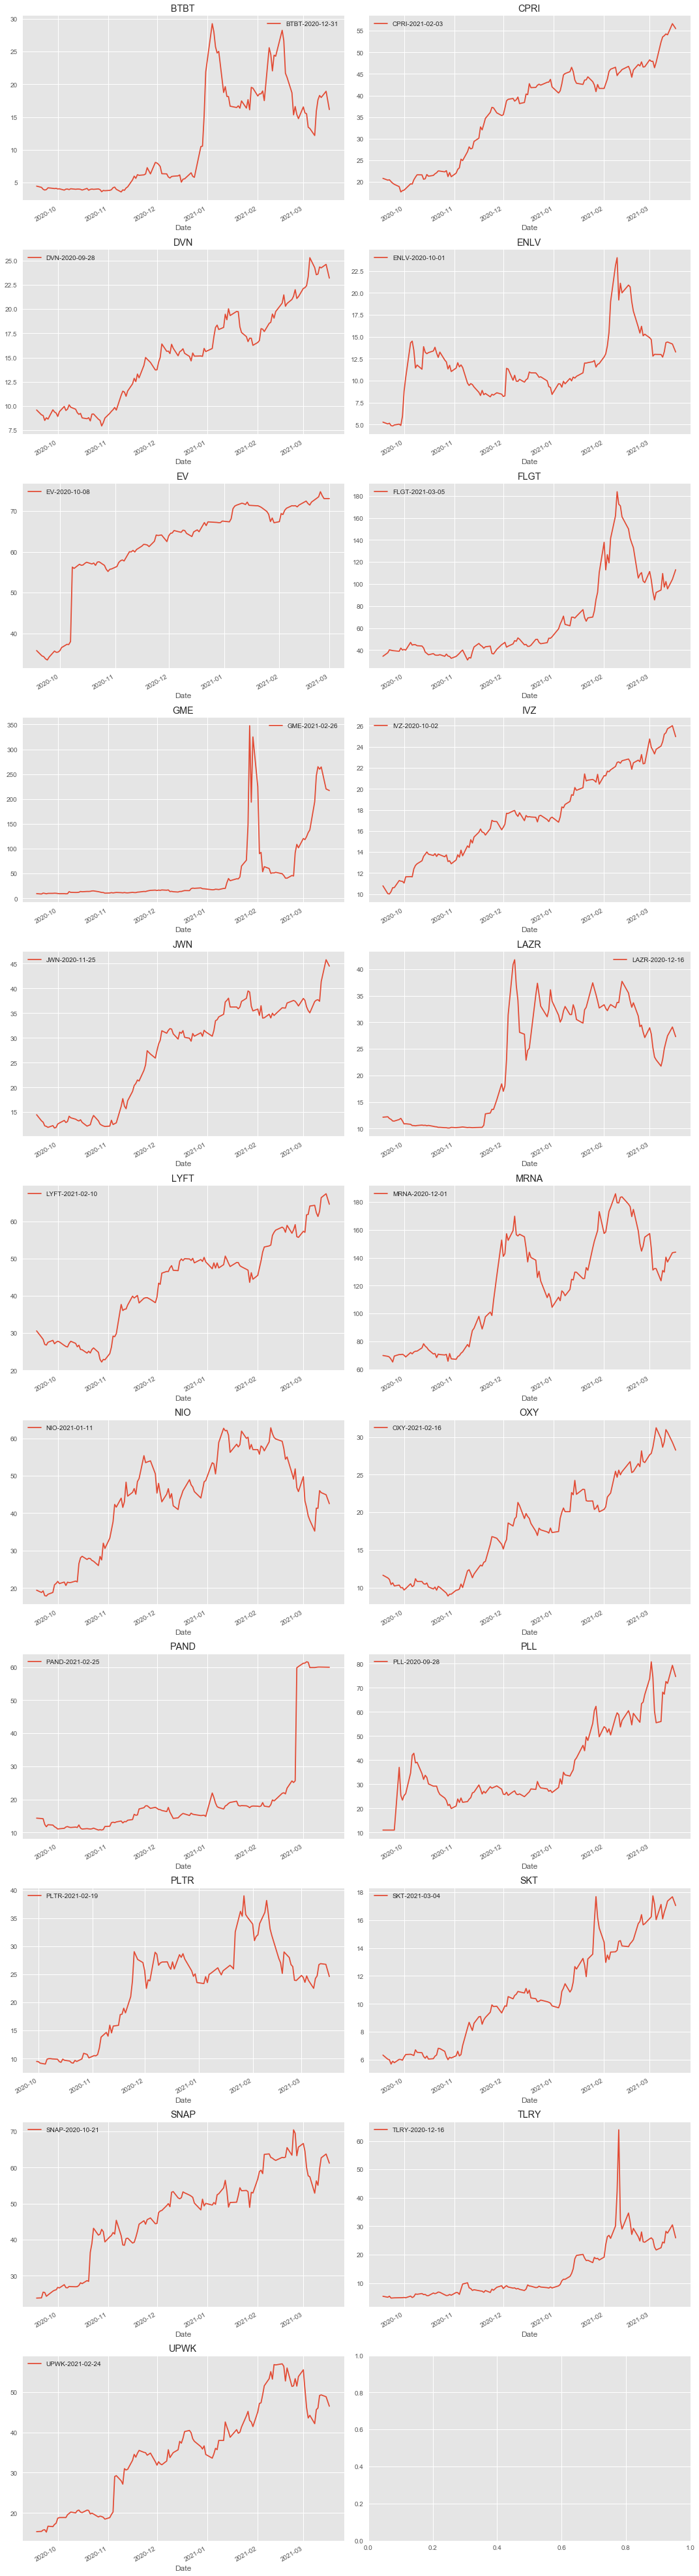

In [80]:
rows = t_cnt//2  if t_cnt % 2 == 0 else t_cnt//2 + 1
cols = 2
fsize = (15, 5*rows)
fig, ax = plt.subplots(rows, cols, figsize=fsize)
keys = list(data_grow.keys())
k = 0

for r in range(rows):
    for c in range(cols):
        d = data_grow[keys[k]]
        dts = np.array(tickers_date[tickers_date['Ticker'] == keys[k]]['Date'].values)
        lbl = keys[k] + '-' + dts[-1]
        d['Adj Close'].plot(ax = ax[r, c], label = lbl)
        ax[r, c].set_title(keys[k])
        ax[r, c].legend(loc='best')            
        k += 1
        if k >= len(keys):
            break
plt.tight_layout()
plt.show()

In [74]:
tickers_date.to_csv('ETC.csv', index=False)